In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
from tqdm.notebook import tqdm
from typing import List, Callable, Dict

warnings.simplefilter("ignore")

from soma.generators import Generator

plt.style.use('seaborn')
plt.style.use('seaborn-notebook')

%load_ext autoreload
%autoreload 2
from soma.generators.nmist import NmistGenerator
from soma.generators.normal import MultivariateNormalGenerator
from soma.generators.dc2 import DC2Generator
from soma.generators.kbest import KBestGenerator
from soma.tests import som_test, knn_test, c2s_test

/home/aalvarez/.local/lib/python3.9/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/aalvarez/.local/lib/python3.9/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar'

In [2]:
#tests = {'knn': knn_test, 'c2st': c2s_test, 'som': som_test}
tests = {'knn': knn_test, 'som': som_test}

In [3]:
def compute_power(gen_a: Generator, gen_b: Generator, test: Callable, *, alpha:float = 0.1, samples: int = 300, repeat: int = 100):
    error1 = 0.
    error2 = 0.
    
    for _ in range(repeat):
        a = gen_a.sample(samples)
        a2 = gen_a.sample(samples)
        b = gen_b.sample(samples)
        ph0 = test(a, a2)
        ph1 = test(a, b)
        error1 += ph0 <= alpha
        error2 += ph1 > alpha
    
    return error1 / repeat, error2 / repeat

def stat_power(gen_a: Generator, gen_b: Generator, tests: Dict[str, Callable], *, alpha:float = 0.1, samples: int = 300, repeat: int = 50, step: int = 10):
    assert gen_a.dimensions == gen_b.dimensions

    dimensions = np.unique(np.concatenate([np.arange(2, gen_a.dimensions, step), [gen_a.dimensions]]))
    
    kbest = KBestGenerator.fit([gen_a, gen_b])
    results = {test_name: np.zeros((len(dimensions), 2), dtype=float) for test_name in tests.keys()}
    for i, d in enumerate(tqdm(dimensions)):
        kbest_a_gen = KBestGenerator(gen_a, d, feat_selector=kbest)
        kbest_b_gen = KBestGenerator(gen_b, d, feat_selector=kbest)
        for test_name, test in tests.items():
            results[test_name][i, :] = compute_power(kbest_a_gen, kbest_b_gen, test, alpha=alpha, samples=samples, repeat=repeat)
    return dimensions, results

In [16]:
def plot_power(dimensions: np.ndarray, results: Dict[str, np.ndarray], *, alpha: float = 0.1):
    fig, axes = plt.subplots(ncols=2, figsize=(12,5), sharex=True)
    for test_name, test_results in results.items():
        axes[0].plot(dimensions, test_results[:, 0], label=test_name)
        axes[1].plot(dimensions, test_results[:, 1], label=test_name)
    axes[0].legend()
    axes[0].axhline(alpha, linestyle='--', color='red')
    axes[0].set_xlabel('Dimensions')
    axes[0].set_ylabel('$\\alpha$')
    axes[1].set_xlabel('Dimensions')
    axes[1].set_ylabel('$\\beta$')
    axes[0].set_title('Type I Error')
    axes[1].set_title('Type II Error')
    plt.tight_layout()
    return fig

# DC2 easy

In [5]:
dc2 = DC2Generator()
dc2_abs = DC2Generator(abs_mag=22)

In [6]:
dc2_dims, dc2_results = stat_power(dc2_abs, dc2, tests)

  0%|          | 0/12 [00:00<?, ?it/s]

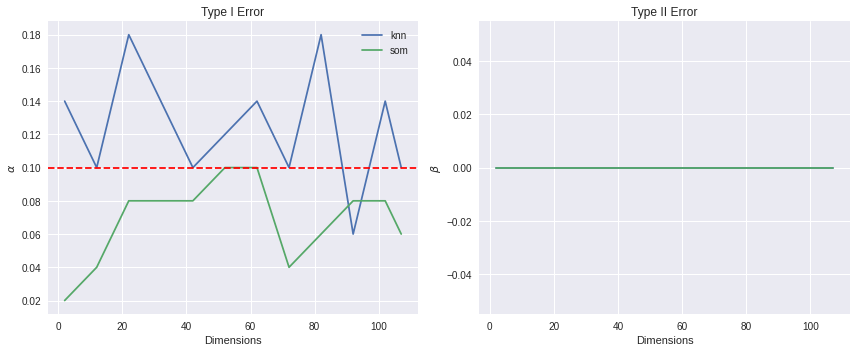

In [7]:
plot_power(dc2_dims, dc2_results)

# DC2 difficult

In [8]:
dc2_snr = DC2Generator(snr=10)

In [9]:
_, dc2_snr_results = stat_power(dc2_snr, dc2, tests)

  0%|          | 0/12 [00:00<?, ?it/s]

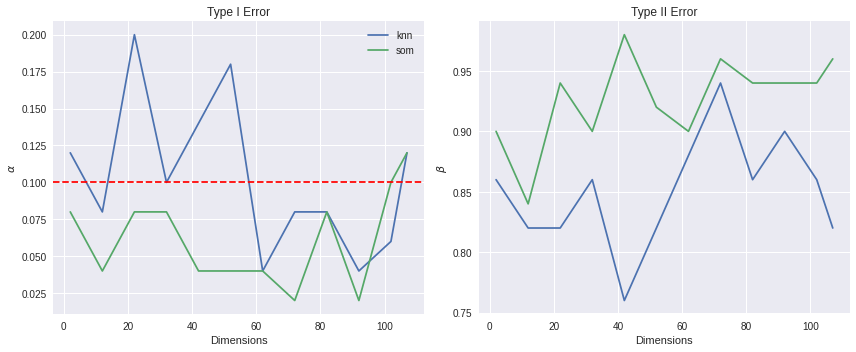

In [10]:
plot_power(dc2_dims, dc2_snr_results)

# NMIST

In [11]:
nmist2 = NmistGenerator(2)
nmist3 = NmistGenerator(3)

In [15]:
nmist_dim, nmist_results = stat_power(nmist2, nmist3, tests, step=30)

  0%|          | 0/28 [00:00<?, ?it/s]

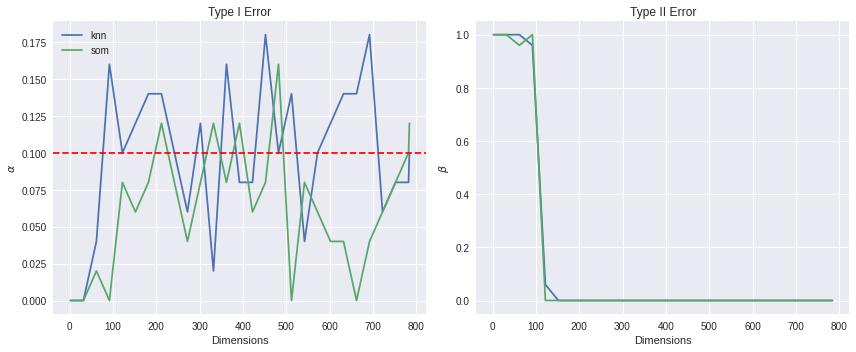

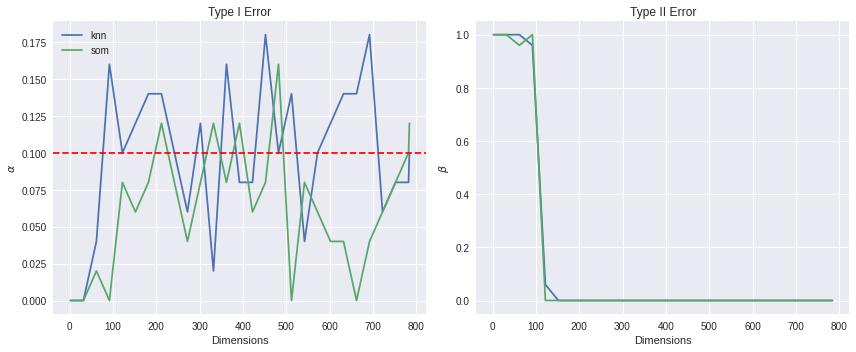

In [18]:
plot_power(nmist_dim, nmist_results)

# Normal

In [19]:
means = np.zeros(1000)
means2 = np.ones(1000)

n1 = MultivariateNormalGenerator(means, cov=np.diag(np.ones(1000)))
n2 = MultivariateNormalGenerator(means2, cov=np.diag(np.ones(1000)))

In [ ]:
normal_dim, normal_results = stat_power(n2, n1, tests, step=200)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
plot_power(normal_dim, normal_results)

In [ ]:
means3 = np.zeros(1000)
means2[0] = 1.

n3 = MultivariateNormalGenerator(means3, cov=np.diag(np.ones(1000)))

In [ ]:
_, n3_results = stat_power(n3, n1, tests, step=200)

In [ ]:
plot_power(normal_dim, n3_results)